In [1]:
import matplotlib.pyplot as plt
import os
from keras.optimizers import Adam
from keras.applications import ResNet50
from PIL import ImageTk, Image
from keras.layers import Add, Multiply
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array
import gc
from tensorflow.keras.losses import categorical_crossentropy
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import categorical_accuracy


import keras as k
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.callbacks import EarlyStopping,ReduceLROnPlateau , ModelCheckpoint
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

Segmentation Models: using `keras` framework.


In [2]:
seed=2023
batch_size= 8
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
img_data_gen_args = dict(rescale = 1/255,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

In [4]:
mask_data_gen_args = dict(rescale = 1/255,  
                      rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      # preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
                         )

In [7]:
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("ML\data\processed/train_images", 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           class_mode=None,
                                                           )  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

Found 3432 images belonging to 1 classes.


In [76]:
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory("ML\data\processed/train_masks", 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)

Found 3432 images belonging to 1 classes.


In [66]:
valid_img_generator = image_data_generator.flow_from_directory("ML\data\processed_trial/val_images/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               class_mode=None) #Default batch size 32, if not specified here


Found 688 images belonging to 1 classes.


In [67]:
valid_mask_generator = mask_data_generator.flow_from_directory("ML\data\processed/val_masks/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


Found 429 images belonging to 1 classes.


In [68]:
train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)


In [55]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [56]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [57]:
from keras import backend as K
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    sum_ = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [58]:
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union


In [17]:
from focal_loss import BinaryFocalLoss

In [18]:
def resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    
    """ Encoder """
    s1 = resnet50.input          ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    # """ Encoder """
    # s1 = resnet50.layers[0].output           ## (512 x 512)
    # s2 = resnet50.layers[4].output        ## (256 x 256)
    # s3 = resnet50.layers[38].output  ## (128 x 128)
    # s4 = resnet50.layers[80].output  ## (64 x 64)

    # """ Bridge """
    # b1 = resnet50.layers[142].output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)


    model = Model(inputs,  outputs, name="ResNet50_U-Net")

    return model

input_shape = (256, 256, 3)
num_classes = 2
model = resnet50_unet(input_shape)
model.compile(optimizer=Adam(learning_rate = 1e-5), loss=BinaryFocalLoss(gamma=2), metrics=[dice_metric,"accuracy"])

model.summary()

Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                     

In [19]:
earlyStop = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience= 20,
                              restore_best_weights= True,
                              verbose = 1)


In [20]:
reduceLearn = ReduceLROnPlateau(monitor='val_accuracy',
                                         patience = 2,
                                         factor=0.5 ,
                                         verbose = 1)

In [21]:
checkpoint = ModelCheckpoint('ML\\models\\best_weight_border.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [22]:
num_train_imgs = len(os.listdir('ML\\data\\processed_trial\\train_images\\train/'))

steps_per_epoch = num_train_imgs //batch_size
steps_per_epoch

688

In [21]:
# tf.keras.utils.plot_model(
#     model,
#     to_file='model.png',
# )

In [24]:
history = model.fit(
    train_generator, validation_data=val_generator,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=steps_per_epoch, 
    epochs=20,
    verbose=1,
    callbacks=[ reduceLearn , checkpoint,earlyStop],
)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000022C2C30DF90>

In [23]:
previousTrainedModel = 'ML\models'
os.makedirs(previousTrainedModel, exist_ok=True)

In [24]:
with open(os.path.join(previousTrainedModel, "resnet_labelled.json"), 'w') as json_file:
    model_json = model.to_json()  # Get the model architecture as JSON string
    json_file.write(model_json)

model.save(os.path.join(previousTrainedModel, "resnet_labelled.h5"))

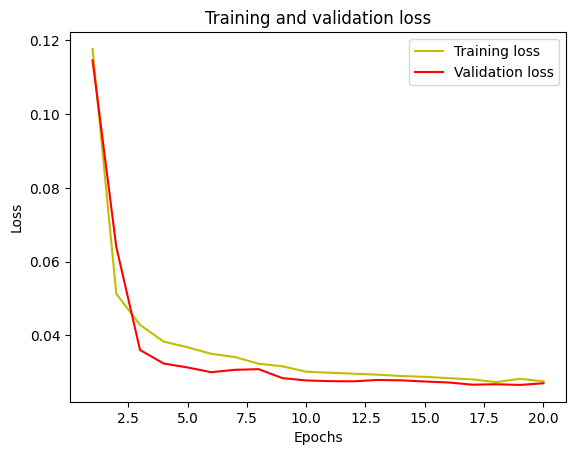

Text(0.5, 1.0, 'Training and validation loss')

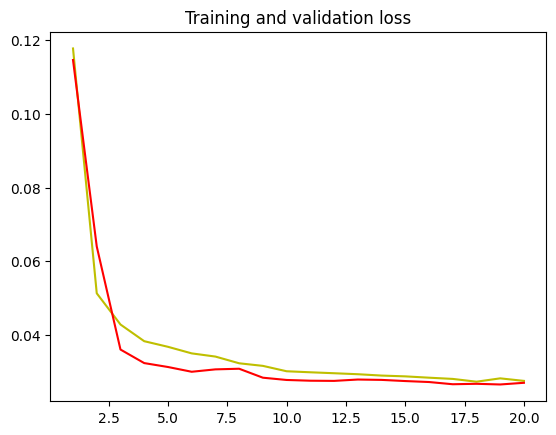

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')  

In [26]:
train_dice = history.history['dice_metric']
val_dice = history.history['val_dice_metric']

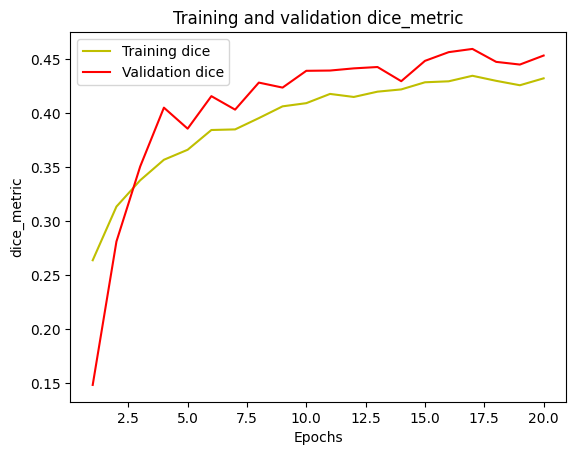

In [27]:
plt.plot(epochs, train_dice, 'y', label='Training dice')
plt.plot(epochs, val_dice, 'r', label='Validation dice')
plt.title('Training and validation dice_metric')
plt.xlabel('Epochs')
plt.ylabel('dice_metric')
plt.legend()
plt.show()

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

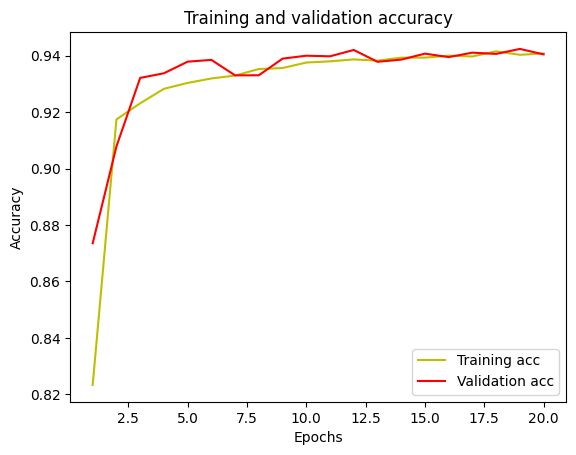

In [29]:
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [30]:
test_img_generator = image_data_generator.flow_from_directory("ML\data\processed/test_images/", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              class_mode=None)

Found 429 images belonging to 1 classes.


In [31]:
test_mask_generator = mask_data_generator.flow_from_directory("ML\data\processed/test_masks/", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)

Found 429 images belonging to 1 classes.


In [33]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] >0.5).astype(np.uint8)


1/1 [==============================] - 2s 2s/step


In [34]:
prediction

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

In [36]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8453238


In [37]:
import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)

1/1 [==============================] - 0s 20ms/step
0.49895477
1/1 [==============================] - 0s 31ms/step
0.49754333
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 17ms/step
0.49858856
1/1 [==============================] - 0s 16ms/step
0.49040222
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 23ms/step
1.0
1/1 [==============================] - 0s 22ms/step
0.6004412
1/1 [==============================] - 0s 24ms/step
0.63487417
1/1 [==============================] - 0s 27ms/step
0.49952698
1/1 [==============================] - 0s 23ms/step
0.88103795
1/1 [==============================] - 0s 29ms/step
0.8453238
1/1 [==============================] - 0s 29ms/step
0.7079049
1/1 [==============================] - 0s 31ms/step
0.6948493
1/1 [==============================] - 0s 30ms/step
0.80495197
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [===================

In [11]:
df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    
    

Mean IoU is:  0.85
